In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [2]:
def LT(t, obsxyz, func):
    """
    Calculates the light time correction to the position vector of an object
    
    Arguments:
    
    t: days
    
    Julian date of observation
    
    obsxyz: np.array
    
    Position vector of observer with respect to the Solar System barycenter.
    
    func: function
    
    A get_target_xyz like function that returns the position and velocity vector of a body at a certain time
    
    Returns:
    
    txyz: np.array
    
    A corrected position vector of the observed object
    
    """
    
    txyz = func(t)
    dist = np.linalg.norm(txyz[0]-obsxyz)
    ltime = float(((dist*u.AU).to(u.m)/c)/u.s)
    d = 10
    while(abs(d)>1e-16):
        txyz = func(t-ltime)
        dist = np.linalg.norm(txyz[0]-obsxyz)
        ltime2 = float(((dist*u.AU).to(u.m)/c)/u.s)
        d = (ltime2-ltime)/ltime
        ltime = ltime2
    return txyz

In [3]:
def Furnisher(k):
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0008.tls.txt')
    if k == '310+341+435':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310+341':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '310+435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341+435':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    elif k == '310':
            spice.furnsh('/Users/user/Downloads/jup310.bsp')
    elif k == '341':
            spice.furnsh('/Users/user/Downloads/jup341.bsp')
    elif k == '435':
            spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [4]:
def SimStart2(t,bsolar,msolar,iJovian,Ms):
    '''
    Starts the simulation. Adds all particles
    
    Arguments:
    
    bsolar: list of strs
    
    The names of the bodies added. Typically: '1','2','3','4', 'Jupiter','Io','Ananke'. 'Jupiter' must be added
    last followed by the satellites in the system
    
    msolar: list of floats
    
    The masses of the bodies in bsolar. Must be at the order of bsolar
    
    iJovian: list, int
    
    The indexes (+1) that the satellites in the solar system have in bsolar
    
    '''
    
    sim = rebound.Simulation()
    k = np.sqrt(Ms*10**9)*(1.49597870700*10**11)**(-1.5) *86400.00000
    sim.G = k**2
    sim.add(m=1.)
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t)
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            ps[j].calculate_orbit(primary=ps[0])
        elif bsolar[j-1] == 'Moon':
            ps[j].calculate_orbit(primary=ps[bsolar.index('Earth')+1])
        else:
            if 'Jupiter' in bsolar:
                ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1])
            else:
                ps[j].calculate_orbit(primary=ps[bsolar.index('5')+1])
    sim.move_to_com()
    return sim

In [5]:
def Integrator(t,bsolar,msolar,iJovian,body1,body2,Ms):
    '''
    Integrates the system. If body1 or body2 refer to the Jupiter Barycenter, while there are bodies in the Jovian system
    teh function will compute the barycenter in the simulation
    
    Arguments:
    
    bsolar
    msolar
    iJovian
    
    body1 and body2: name in str
    
    The spice names of the bodies that we want to look into to check the error of our integrator
    
     '''
    sim = SimStart2(t,bsolar,msolar,iJovian,Ms)
    year = 365.25 # days
    tmax = 1*year
    sim.integrate(tmax)
    return sim

In [6]:
def ErrorSource(t,bsolar,mass,iJovian,body1,body2,Ms):
    '''
    Returns the error of the chosen bodies as well as the entire system
    
    '''
    x,y,z,xm,ym,zm,times,distance,xan,yan,zan = Integrator(t,bsolar,mass,iJovian,body1,body2,Ms)
    if (body2 == '5' or body1 == '5') and len(iJovian)>1:
        dist1 = np.array(xan)
        dist2 = np.array(yan)
        dist3 = np.array(zan)
    elif body2 == 'Sun':
        temp = 0
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
        dist3 = z[bsolar.index(body1)+1] - z[temp]
    else:
        temp = bsolar.index(body2)+1
        dist1 = x[bsolar.index(body1)+1] - x[temp]
        dist2 = y[bsolar.index(body1)+1] - y[temp]
        dist3 = z[bsolar.index(body1)+1] - z[temp]
    return np.array(dist1-xm),np.array(dist2-ym),np.array(dist3-zm),times,distance,x,y,z,xm,ym,zm,xan,yan,zan

In [7]:
# From 432 (km^3/s^2)
GMEarth = 398600.435420
GMMoon = 27068703.151194

GMMercuryB = 22031.780000
GMVenusB = 324858.592000
GMEarthB = 403503.235502
GMMarsB = 42828.375214
GMJupiterB = 126712764.133446
GMSaturnB = 37940585.200000
GMUranusB = 5794556.465752
GMNeptuneB = 6836527.100580
GMSun = 132712440041.939400 # Just Sun
GMSunterr = GMSun + GMMercuryB + GMVenusB + GMEarthB + GMMarsB

# From 310

GMJupiter = 1.266865341960128E+08
GMIo = 5.959924010272514E+03
GMEuropa = 3.202739815114734E+03
GMGanymede = 9.887819980080976E+03
GMCallisto = 7.179304867611079E+03
GMAmalthea = 1.487604677404272E-01
GM10310 = 1.327132332639000E+11

GMSaturnB310 = 3.794058500000000E+07
GMUranusB310 = 5.794548600000000E+06
GMNeptuneB310 = 6.836527100580000E+06
GMJupiterB310 = 1.267127641334463E+08

In [19]:
MMercuryB = GMMercuryB/GMSun
MVenusB = GMVenusB/GMSun
MEarthB = GMEarthB/GMSun
MEarth = GMEarth/GMSun
MMoon = GMMoon/GMSun
MMarsB = GMMarsB/GMSun
MJupiter = (GMJupiterB-GMIo-GMEuropa-GMGanymede-GMCallisto)/GMSun
MSaturnB = GMSaturnB/GMSun
MUranusB = GMUranusB/GMSun
MNeptuneB = GMNeptuneB/GMSun
MIo = GMIo/GMSun
MEuropa = GMEuropa/GMSun
MGanymede = GMGanymede/GMSun
MCallisto = GMCallisto/GMSun
MAmalthea = GMAmalthea/GMSun

In [20]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

In [21]:
Furnisher("310+341+435")

In [22]:
def get_astroquery_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are "geometric","astrometric" and 
    "apparent"
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        """
        
        obj = Horizons(id = name, location = loc, epochs = t, id_type = 'majorbody')
        obj1 = obj.vectors(aberrations = cor, refplane = 'earth')
        xyz = np.array([float(obj1['x']),float(obj1['y']),float(obj1['z'])])
        uvw = np.array([float(obj1['vx']),float(obj1['vy']),float(obj1['vz'])])
        obj2 = obj.ephemerides(refsystem = 'J2000', extra_precision = True)
        radec = np.array([float(obj2['RA']),float(obj2['DEC']),float(obj1['range'])])
        return xyz,uvw,radec
    return get_target_xyz 

In [23]:
def monthToNum(shortMonth):
    
    '''
    
    Returns the name of a month that a number corresponds to and vice versa
    
    Arguments:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October)
    
    Returns:
    
    shortMonth: str
    
    Either the first three letters of a month or its number (e.g. 01 for January, 10 for October),
    the other one to the one that was given as an argument
    
    '''
    
    return{
        'Jan' : '01', 'Feb' : '02','Mar' : '03','Apr' : '04','May' : '05','Jun' : '06','Jul' : '07','Aug' : '08',
        'Sep' : '09', 'Oct' : '10','Nov' : '11','Dec' : '12','01' : 'Jan','02' : 'Feb','03' : 'Mar','04' : 'Apr',
        '05' : 'May','06' : 'Jun','07' : 'Jul','08' : 'Aug','09' : 'Sep', '10' : 'Oct','11' : 'Nov','12' : 'Dec'}[shortMonth]

In [24]:
def JD_to_SpiceJD(jd):
    '''
    
    Converts jd date to spice units of time.
    
    Arguments:
    
    jd: float
    
    A jd time in days
    
    Returns:
    
    newjd: float
    
    A spice usable time in seconds
    
    
    '''
    t = Time(jd, format='jd', scale='utc')
    k = t.fits
    print(k)
    year = k[0:4]
    month = k[5:7]
    day = k[8:10]
    hours = k[11:13]
    minutes = k[14:16]
    seconds = k[17:23]
    newmnth = monthToNum(month)
    utc = newmnth + ' ' + day + ", " + year
    newjd = spice.str2et(utc) + int(hours)*3600 + int(minutes)*60 + float(seconds)
    return newjd

In [25]:
def CordConv(xyz):
    '''
    This function takes in a position vector of a body relative to an observer and returns a radec.
    
    Arguments:
    
    xyz: numpy array
    
    Should be three values, the x,y,z of the position vector
    
    Returns:
    
    radec: numpy array
    
    Two values, the first for right ascension and the second for declination
    
    '''
    DEC = -(np.arccos(xyz[2]/np.linalg.norm(xyz))-np.pi/2)
    RA = (np.arctan2(xyz[1],xyz[0]))
    while (RA > 2*np.pi):
        RA -= 2*np.pi   
    while (RA < 0):
        RA += 2*np.pi   
    return np.array([RA*180/np.pi,DEC*180/np.pi])

In [26]:
def FinderSpicef51(name,t):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory. Used to test the correspondence
    of spice and Horizons.
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    thor = Time(t, format='jd', scale='utc')
    thor = thor.tt.value
    tstr = "jd " + str(t) + " utc"
    ts = spice.str2et(tstr)
    get_earth = get_astroquery_function('0','geometric','f51')
    get_jup = get_spice_function(name,"NONE","0")
    exyz = get_earth(thor)
    jxyz = get_jup(ts)
    fxyz = LT(ts, -exyz[0], get_jup)
    vectors = fxyz[0] + exyz[0]
    return CordConv(vectors)

In [27]:
def FinderHorizonsf51(name,t):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory from the Horizons data base.
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    thor = Time(t, format='jd', scale='utc')
    thor = thor.tt.value
    get_pans = get_astroquery_function(name,'astrometric','f51')
    vecs2 = get_pans(thor)
    return CordConv(vecs2[0])

In [28]:
err = []
for i in range(0,100):
    err.append(206245 * np.pi/180 * (FinderSpicef51('5',2452993.114031909+100*i)-FinderHorizonsf51('5',2452993.114031909+100*i)))
    print(i)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


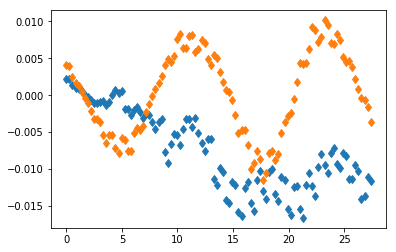

In [29]:
x = np.linspace(0,100,100)
plt.plot(x/3.6524,err,"d")

In [30]:
def FinderReboundf51(name,t):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory a number of years before
    the time of observation and integrates it to the time of observation using rebound.
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    thor = Time(t, format='jd', scale='utc')
    thor = thor.tt.value
    tstr = "jd " + str(t) + " utc"
    ts = spice.str2et(tstr)
    get_earth = get_astroquery_function('0','geometric','f51')
    sec_year = 86400*365.25
    sim = Integrator(ts - 1*sec_year,['1','2','3','4','6','7','8',
        'Jupiter','Io','Europa','Ganymede','Callisto',name],[MMercuryB,MVenusB,
        MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,
        MCallisto,0],[9,10,11,12,13,14,15],name,'5',GMSun)
    ps = sim.particles
    dist = np.sqrt((ps[-1].x-ps[3].x)**2 + (ps[-1].y-ps[3].y)**2 + (ps[-1].z-ps[3].z)**2)
    ltime = float(((dist*u.AU).to(u.m)/c)/u.s)
    print(sim.t - ltime/(24*3600))
    sim.integrate(sim.t - ltime/(24*3600))
    ps = sim.particles
    AnSun = np.array([float(ps[-1].x),float(ps[-1].y),float(ps[-1].z)])
    F51Sun = get_earth(thor)
    vectors = AnSun + F51Sun[0]
    return CordConv(vectors)

In [37]:
206245 * np.pi/180 * (FinderReboundf51('Ananke',2452993.114031909) - FinderHorizonsf51('Ananke',2452993.114031909))


365.2202723919297


array([0.01021983, 0.00428754])

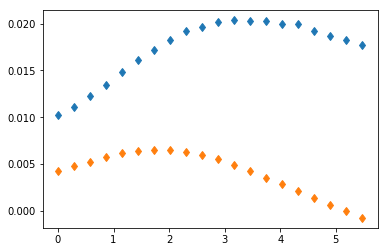

In [34]:
x = np.linspace(0,20,20)
plt.plot(x/3.6525,error,"d")

In [36]:
def FinderReboundf51_2(name,t):
    '''
    
    Finds the radec of objects in the jovian system from the pansstars observatory a number of years before
    the time of observation and integrates it to the time of observation using rebound.
    
    Arguments:
    
    name: str
    
    The name of the object in spice documentation. See Summary_Names.txt
    
    t: float
    
    A julian date
    
    '''
    thor = Time(t, format='jd', scale='utc')
    thor = thor.tt.value
    tstr = "jd " + str(t) + " utc"
    ts = spice.str2et(tstr)
    get_earth = get_astroquery_function('0','geometric','f51')
    sec_year = 86400*365.25
    sim = Integrator(ts - 1*sec_year,['1','2','3','4','6','7','8',
        'Jupiter','Io','Europa','Ganymede','Callisto',name],[MMercuryB,MVenusB,
        MEarthB,MMarsB,MSaturnB,MUranusB,MNeptuneB,MJupiter,MIo,MEuropa,MGanymede,
        MCallisto,0],[9,10,11,12,13,14,15],name,'5',GMSun)
    ps = sim.particles
    dist = np.sqrt((ps[-1].x-ps[3].x)**2 + (ps[-1].y-ps[3].y)**2 + (ps[-1].z-ps[3].z)**2)
    ltime = float(((dist*u.AU).to(u.m)/c)/u.s)
    print(sim.t - ltime/(24*3600))
    sim.integrate(sim.t - ltime/(24*3600))
    ps = sim.particles
    AnSun = np.array([float(ps[-1].x),float(ps[-1].y),float(ps[-1].z)])
    F51Sun = get_earth(thor)
    vectors = AnSun + F51Sun[0]
    return CordConv(vectors)